In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
# adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
extra = pd.read_csv('banksy_cluster.csv', index_col=0)
adata.obs = adata.obs.join(extra.banksy_cluster)
adata.obs['banksy_cluster'] = adata.obs['banksy_cluster'].astype('category')
# adata.obsm['X_umap'] = extra[['0', '1']].values

In [6]:
from spaceoracle.gene_factory import GeneFactory

gf = GeneFactory.from_json(
    adata, 
    '/ix/djishnu/shared/djishnu_kor11/lasso_runs/slideseq_mouse_lymphnode/run_params.json', 
    # '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode/run_params.json', 
    override_params={
        # 'save_dir': '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode'
        'save_dir': '/ix/djishnu/shared/djishnu_kor11/lasso_runs/slideseq_mouse_lymphnode'
    }
)
assert len(gf.queue.remaining_genes) == 0

2025-06-13 11:48:47.040620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [7]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    gf.adata, 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)

### Cell type

In [7]:
interactions = {}

for ct in adata.obs.cell_type.unique():
    interactions[ct] = bdb.collect_interactions(cell_type=ct, annot='cell_type')

In [8]:
interactions['Th2'].query('gene=="Il2ra"').groupby('interaction').sum().sort_values(
    by='beta', ascending=False).head(10)

,gene,beta,interaction_type
interaction,,,
beta_C3$Itgb2,Il2ra,0.003608,ligand-receptor
beta_Ccl5$Ccr4,Il2ra,0.001757,ligand-receptor
beta_Ccl22$Ccr4,Il2ra,0.001535,ligand-receptor
beta_Mdk$Ncl,Il2ra,0.000748,ligand-receptor
beta_Il2$Il2rb,Il2ra,0.000439,ligand-receptor
beta_C3$Itgam,Il2ra,0.000243,ligand-receptor
beta_Cxcl13$Cxcr3,Il2ra,0.000228,ligand-receptor
beta_Nampt$Itgb1,Il2ra,0.000141,ligand-receptor
beta_Ccl17$Ccr4,Il2ra,0.000137,ligand-receptor


In [28]:
# dfr = interactions['Th2'].query('gene.isin(["Il2ra", "Il2rb", "Il2rg"])').groupby(
#     'interaction').sum().sort_values(
#     by='beta', ascending=False)

dfr = interactions['Th2'].query('gene.isin(["Il2ra", "Il2rb", "Il2rg", "Gata3"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

dfr['beta'] = dfr['beta'] * 100
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')

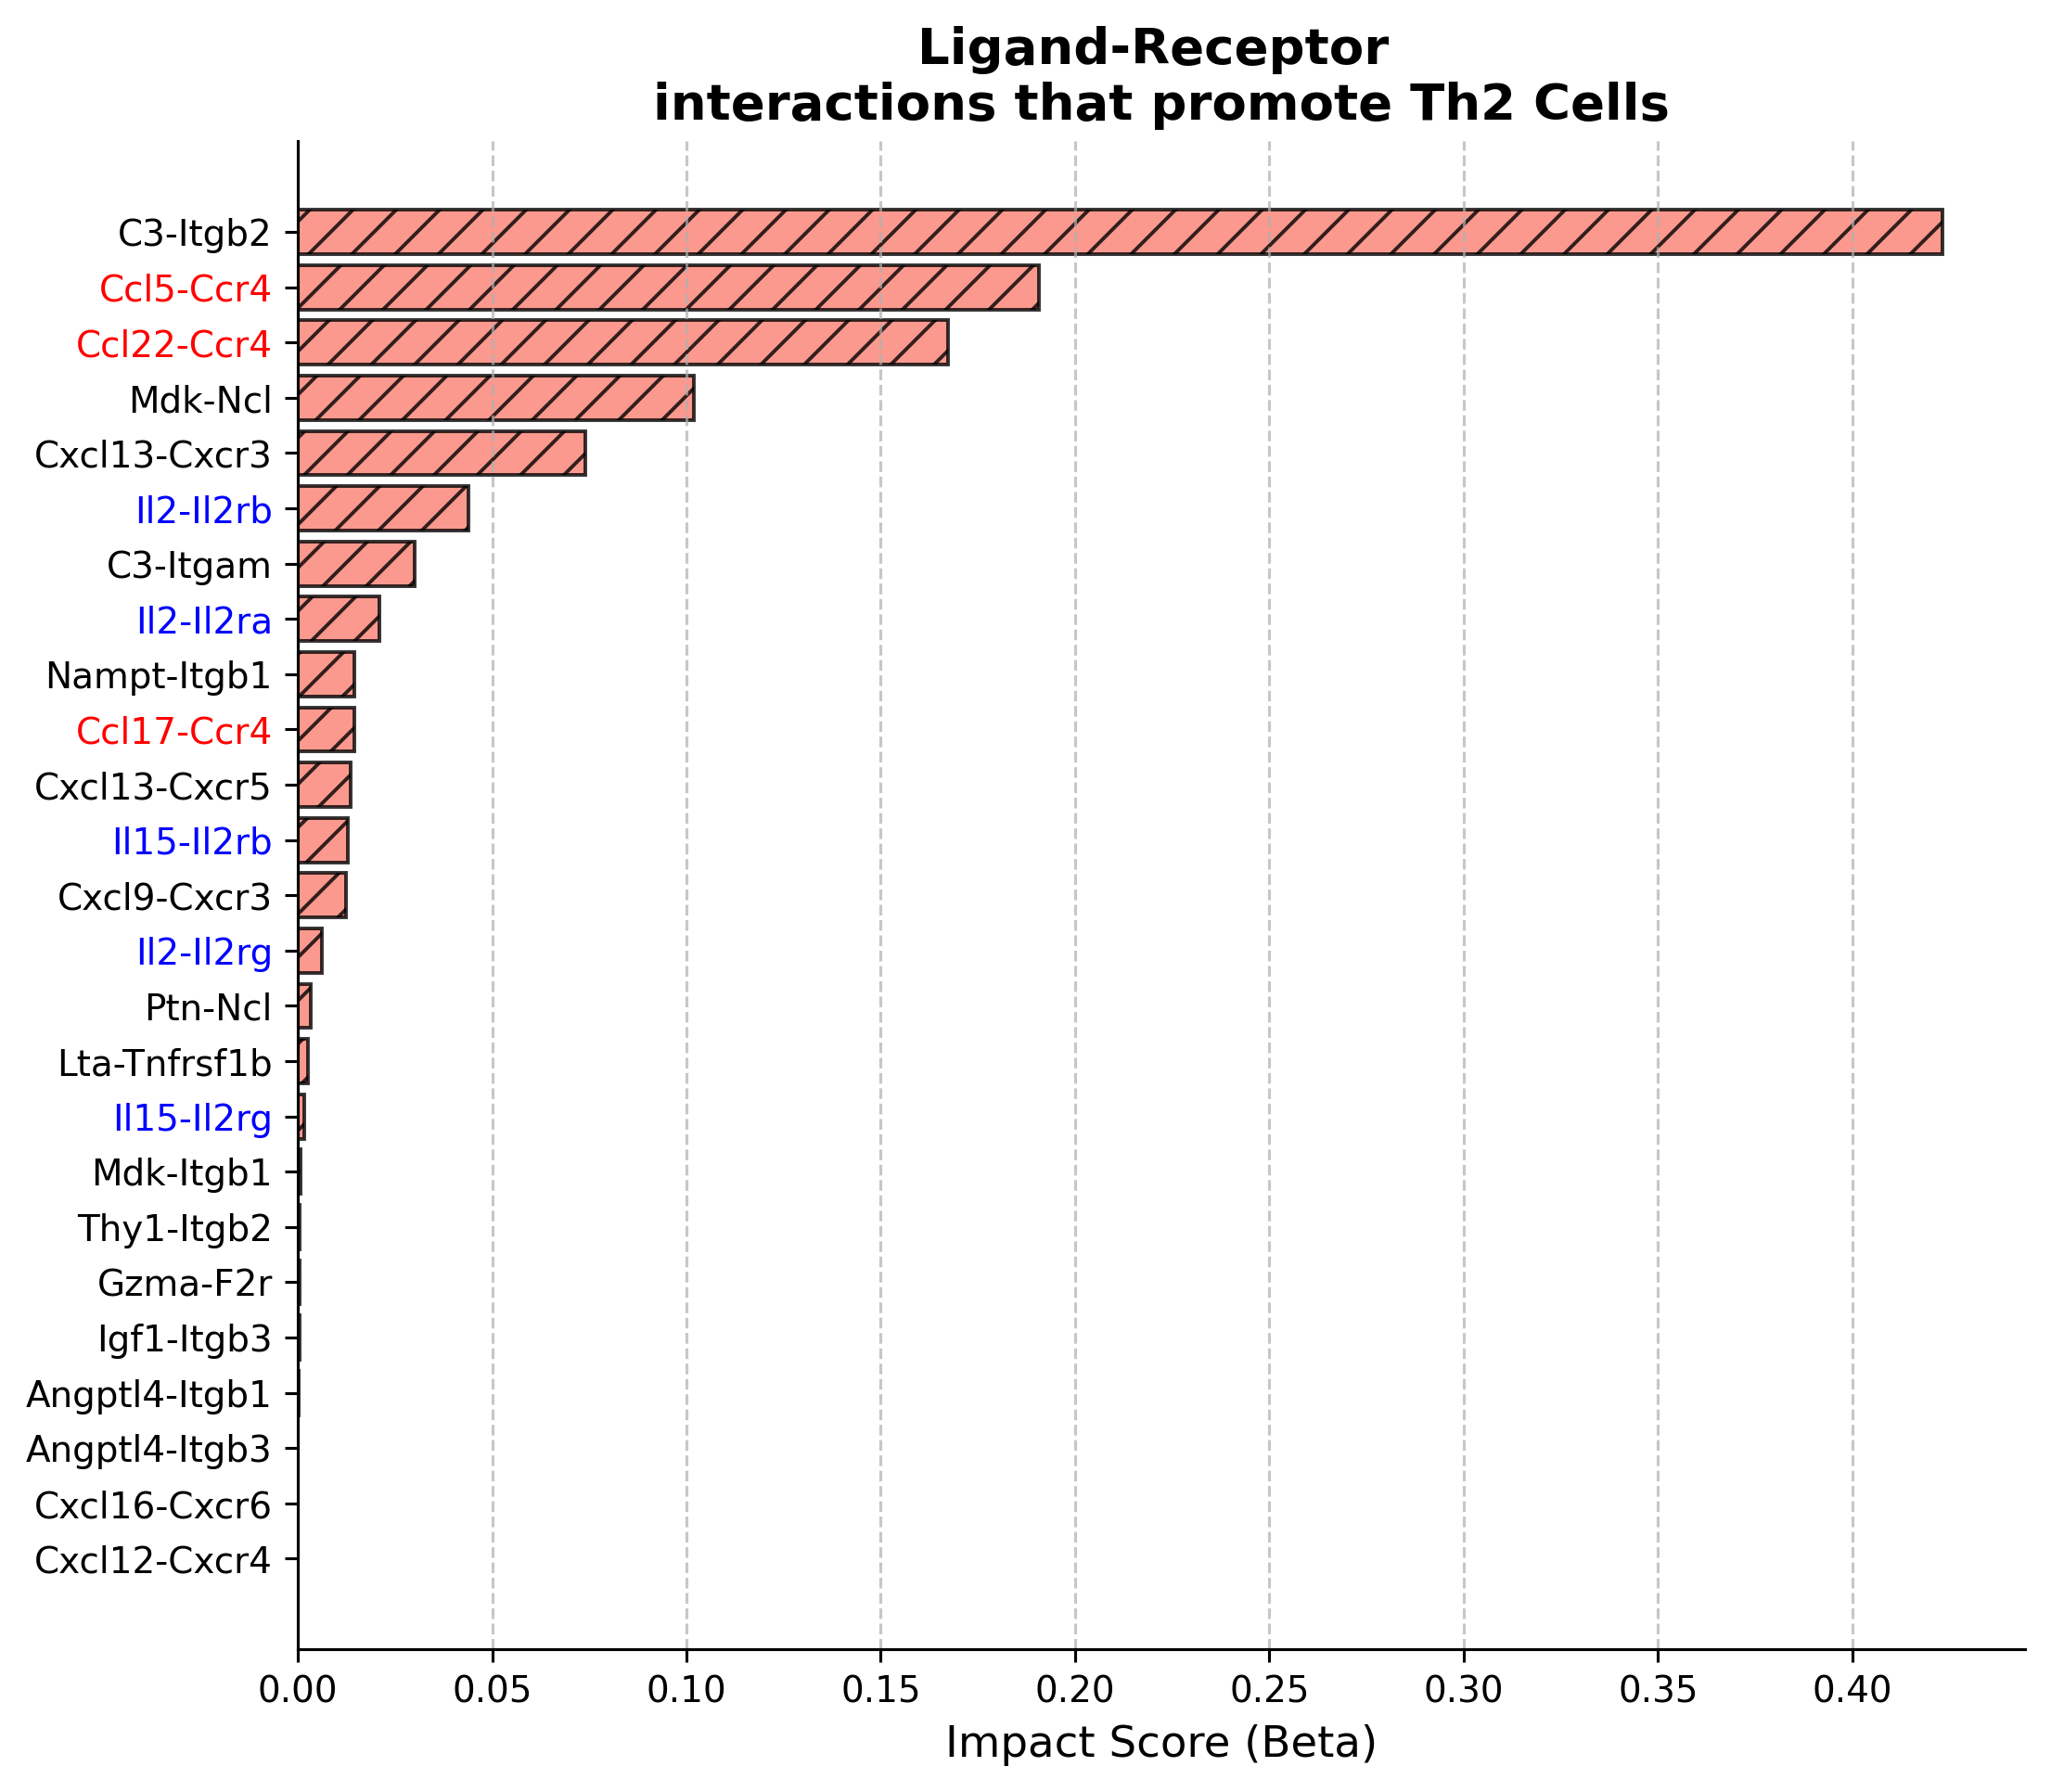

In [29]:
top_interactions = dfr[dfr['beta'] > 0].sort_values(
    by='beta', ascending=False).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that promote Th2 phenotype', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

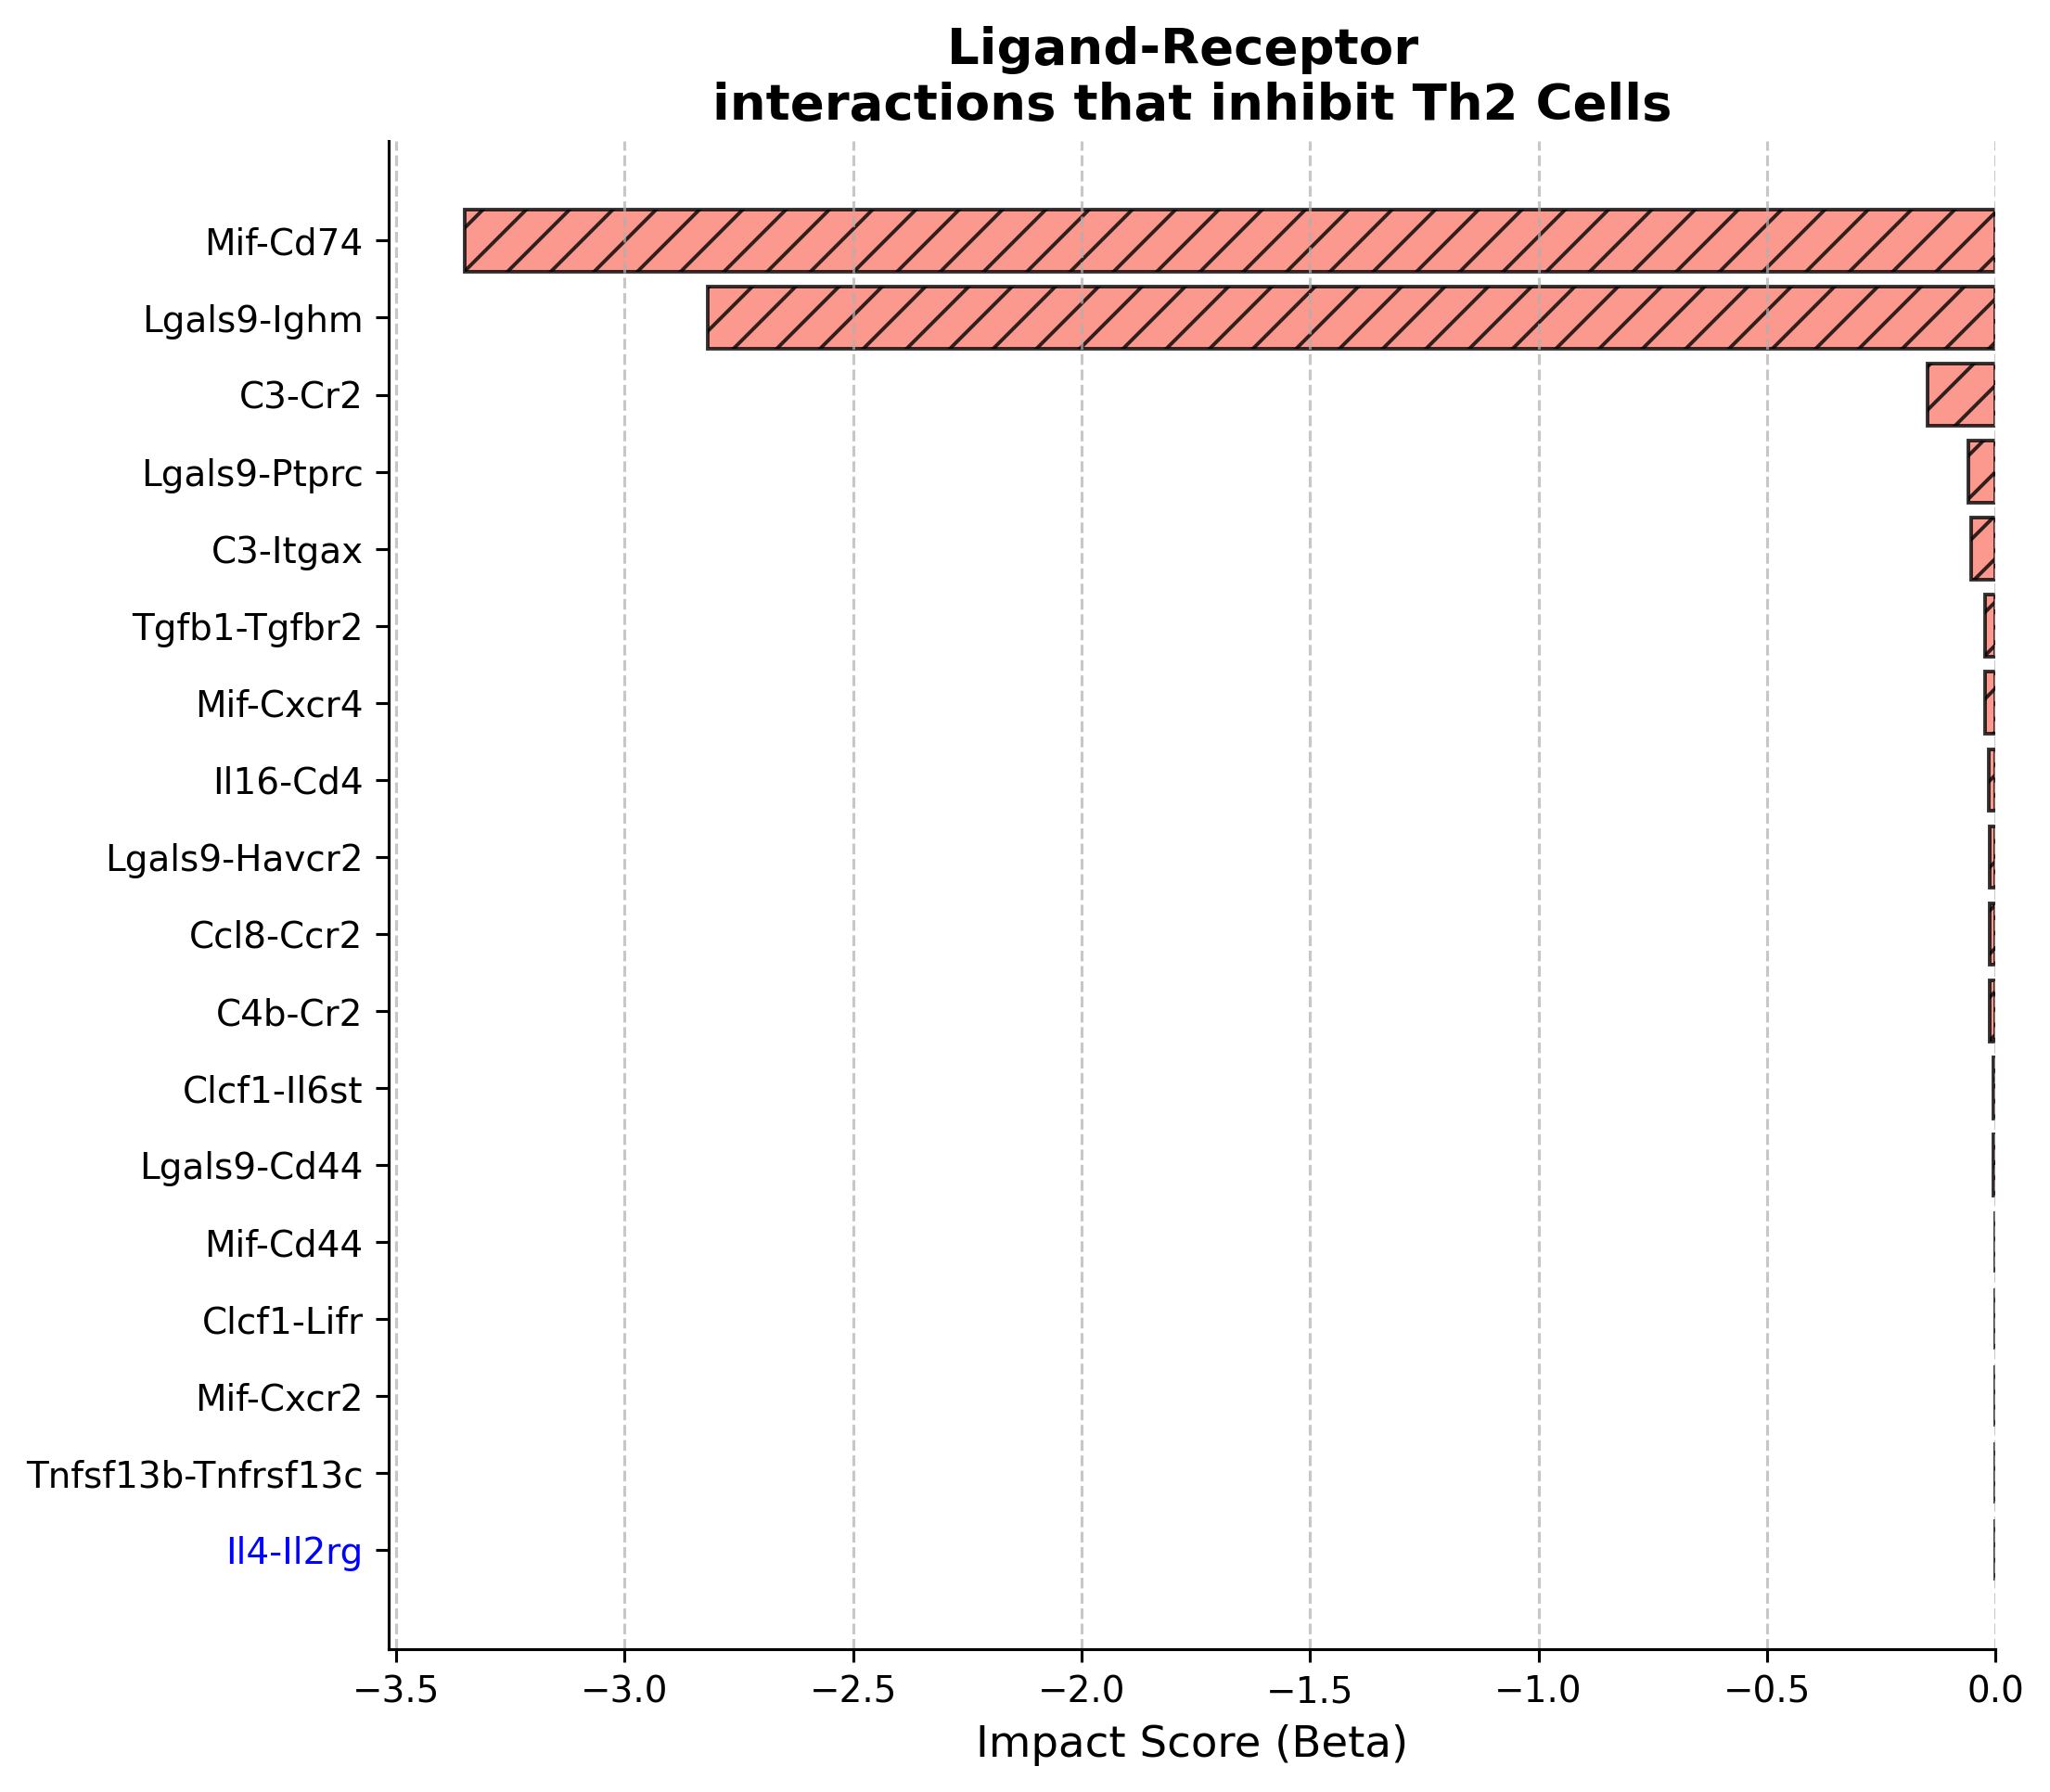

In [30]:
top_interactions = dfr[dfr['beta'] < 0].sort_values(
    by='beta', ascending=True).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that inhibit Th2 Cells', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [22]:
dfr = interactions['Tfh'].query('gene.isin(["Icos", "Bcl6", "Cxcr5", "Pdcd1"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)


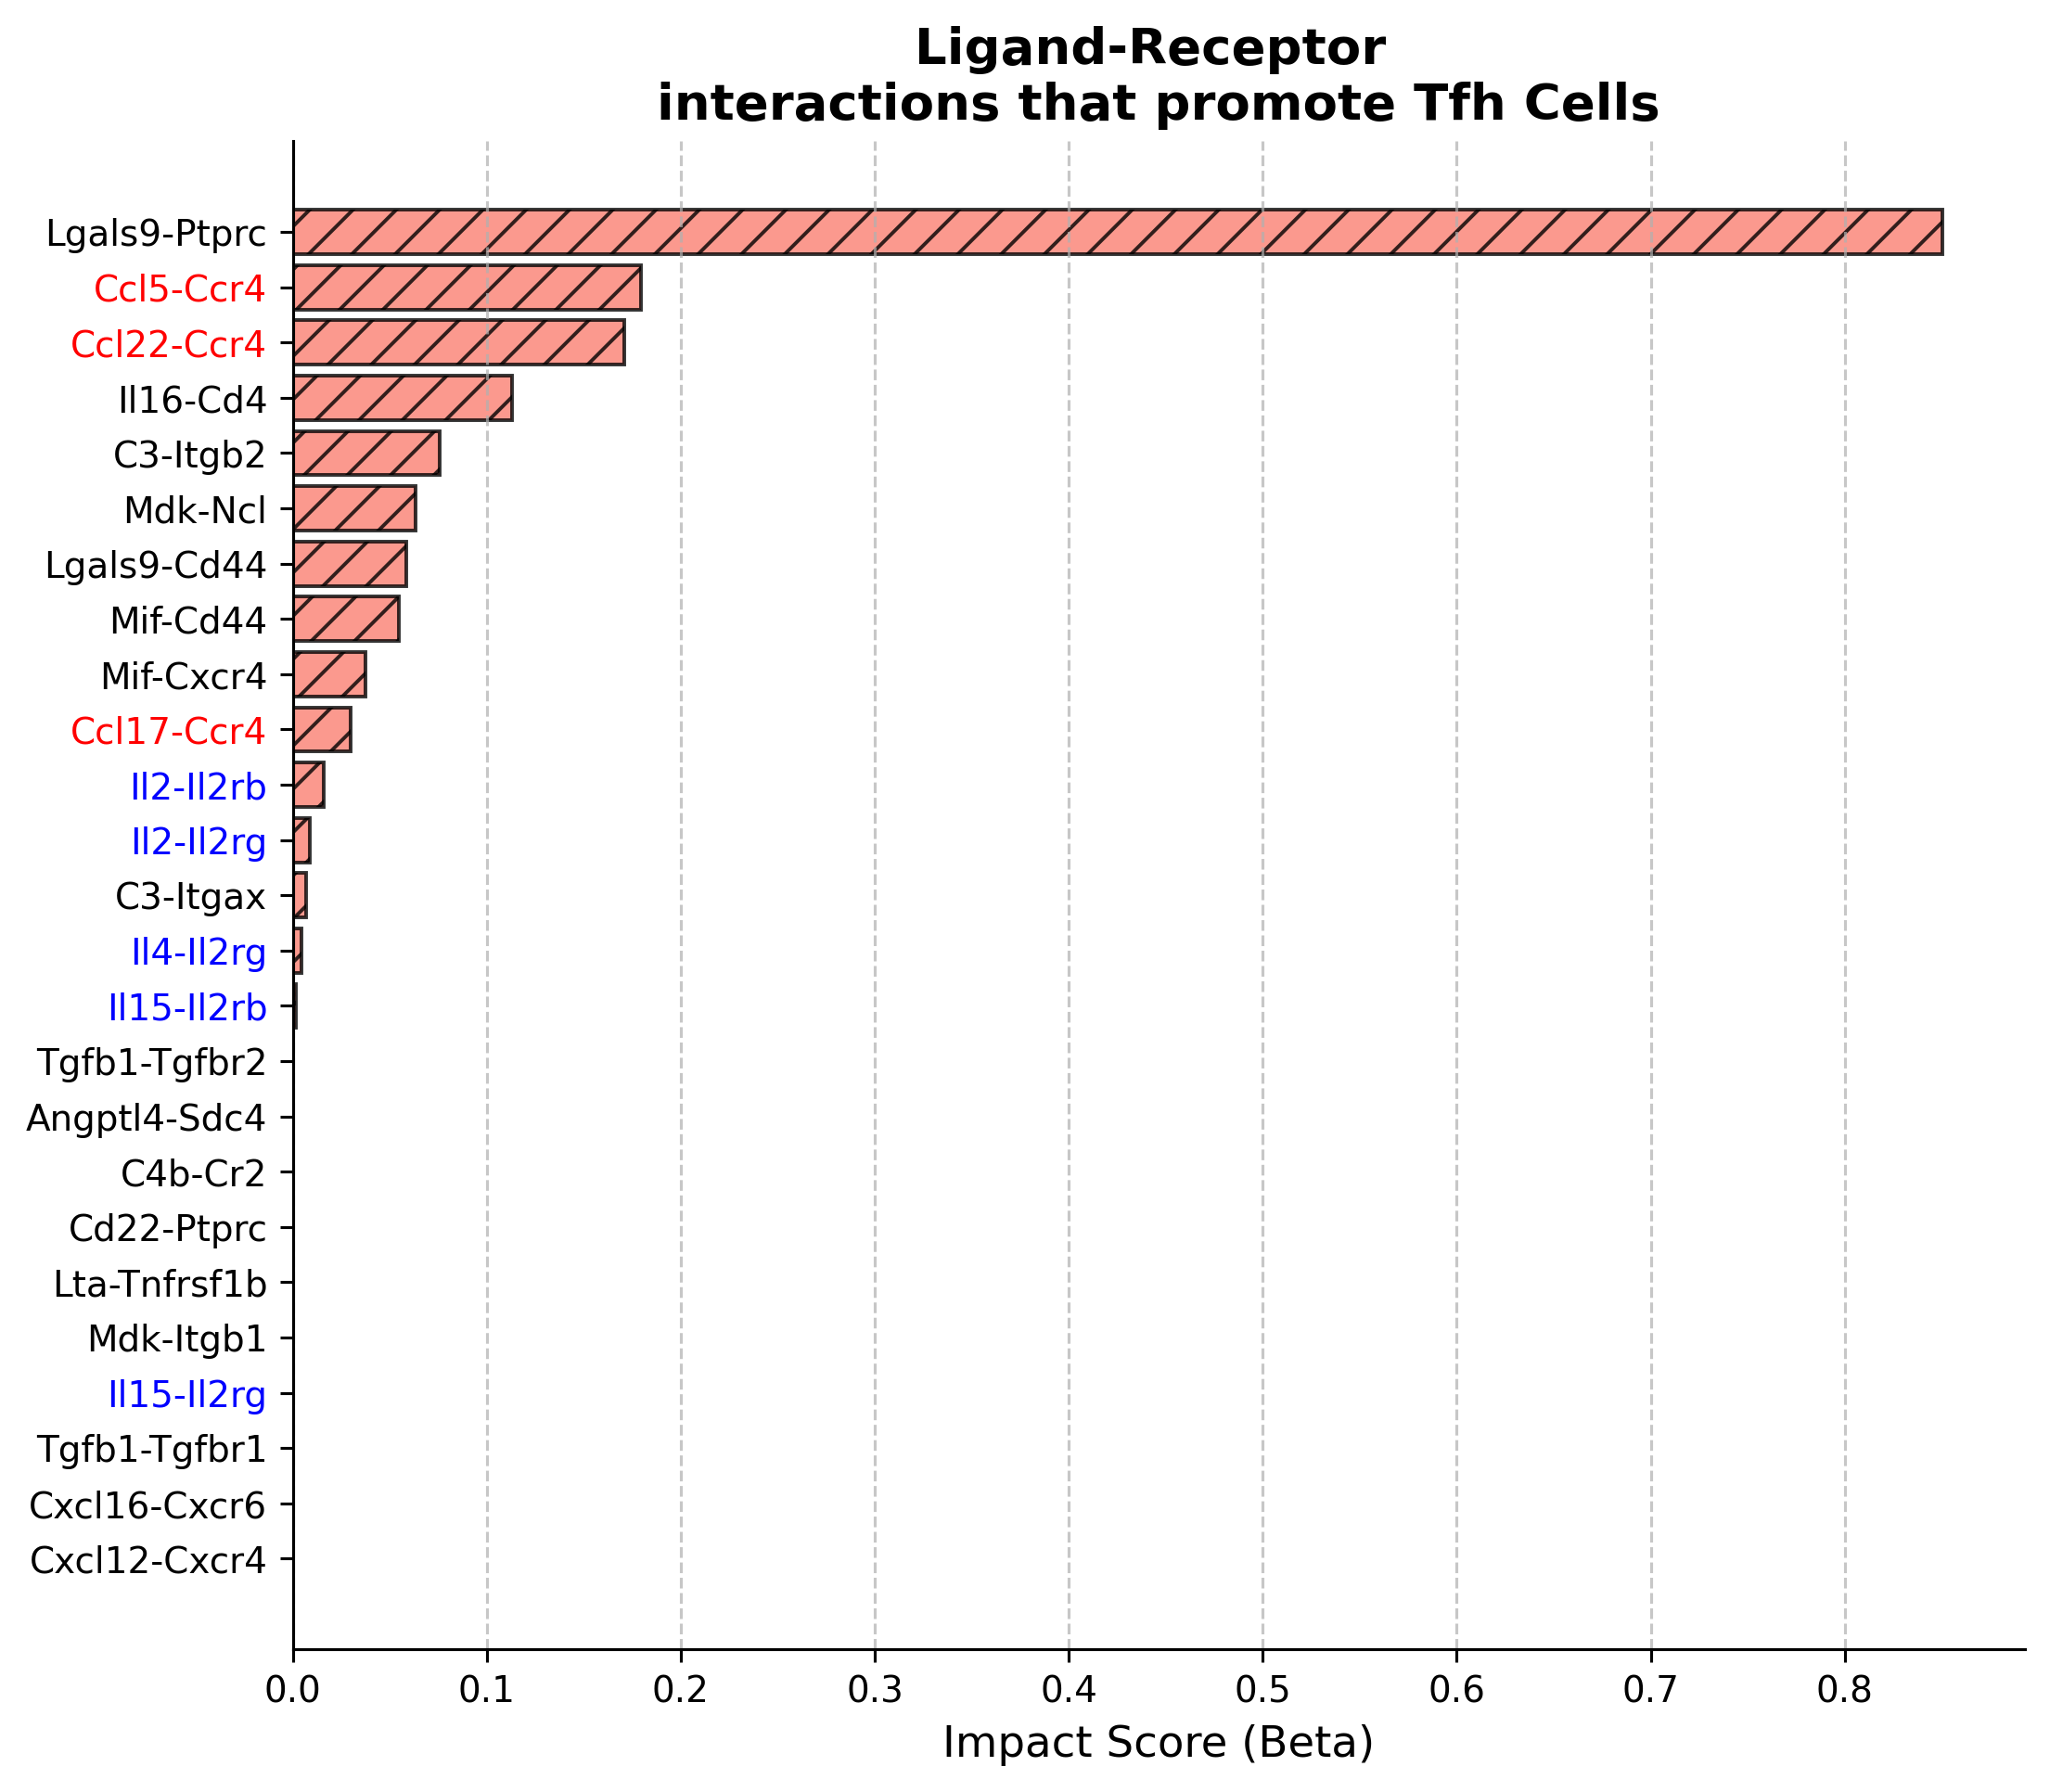

In [27]:
top_interactions = dfr[dfr['beta'] > 0].sort_values(
    by='beta', ascending=False).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that promote Tfh Cells', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

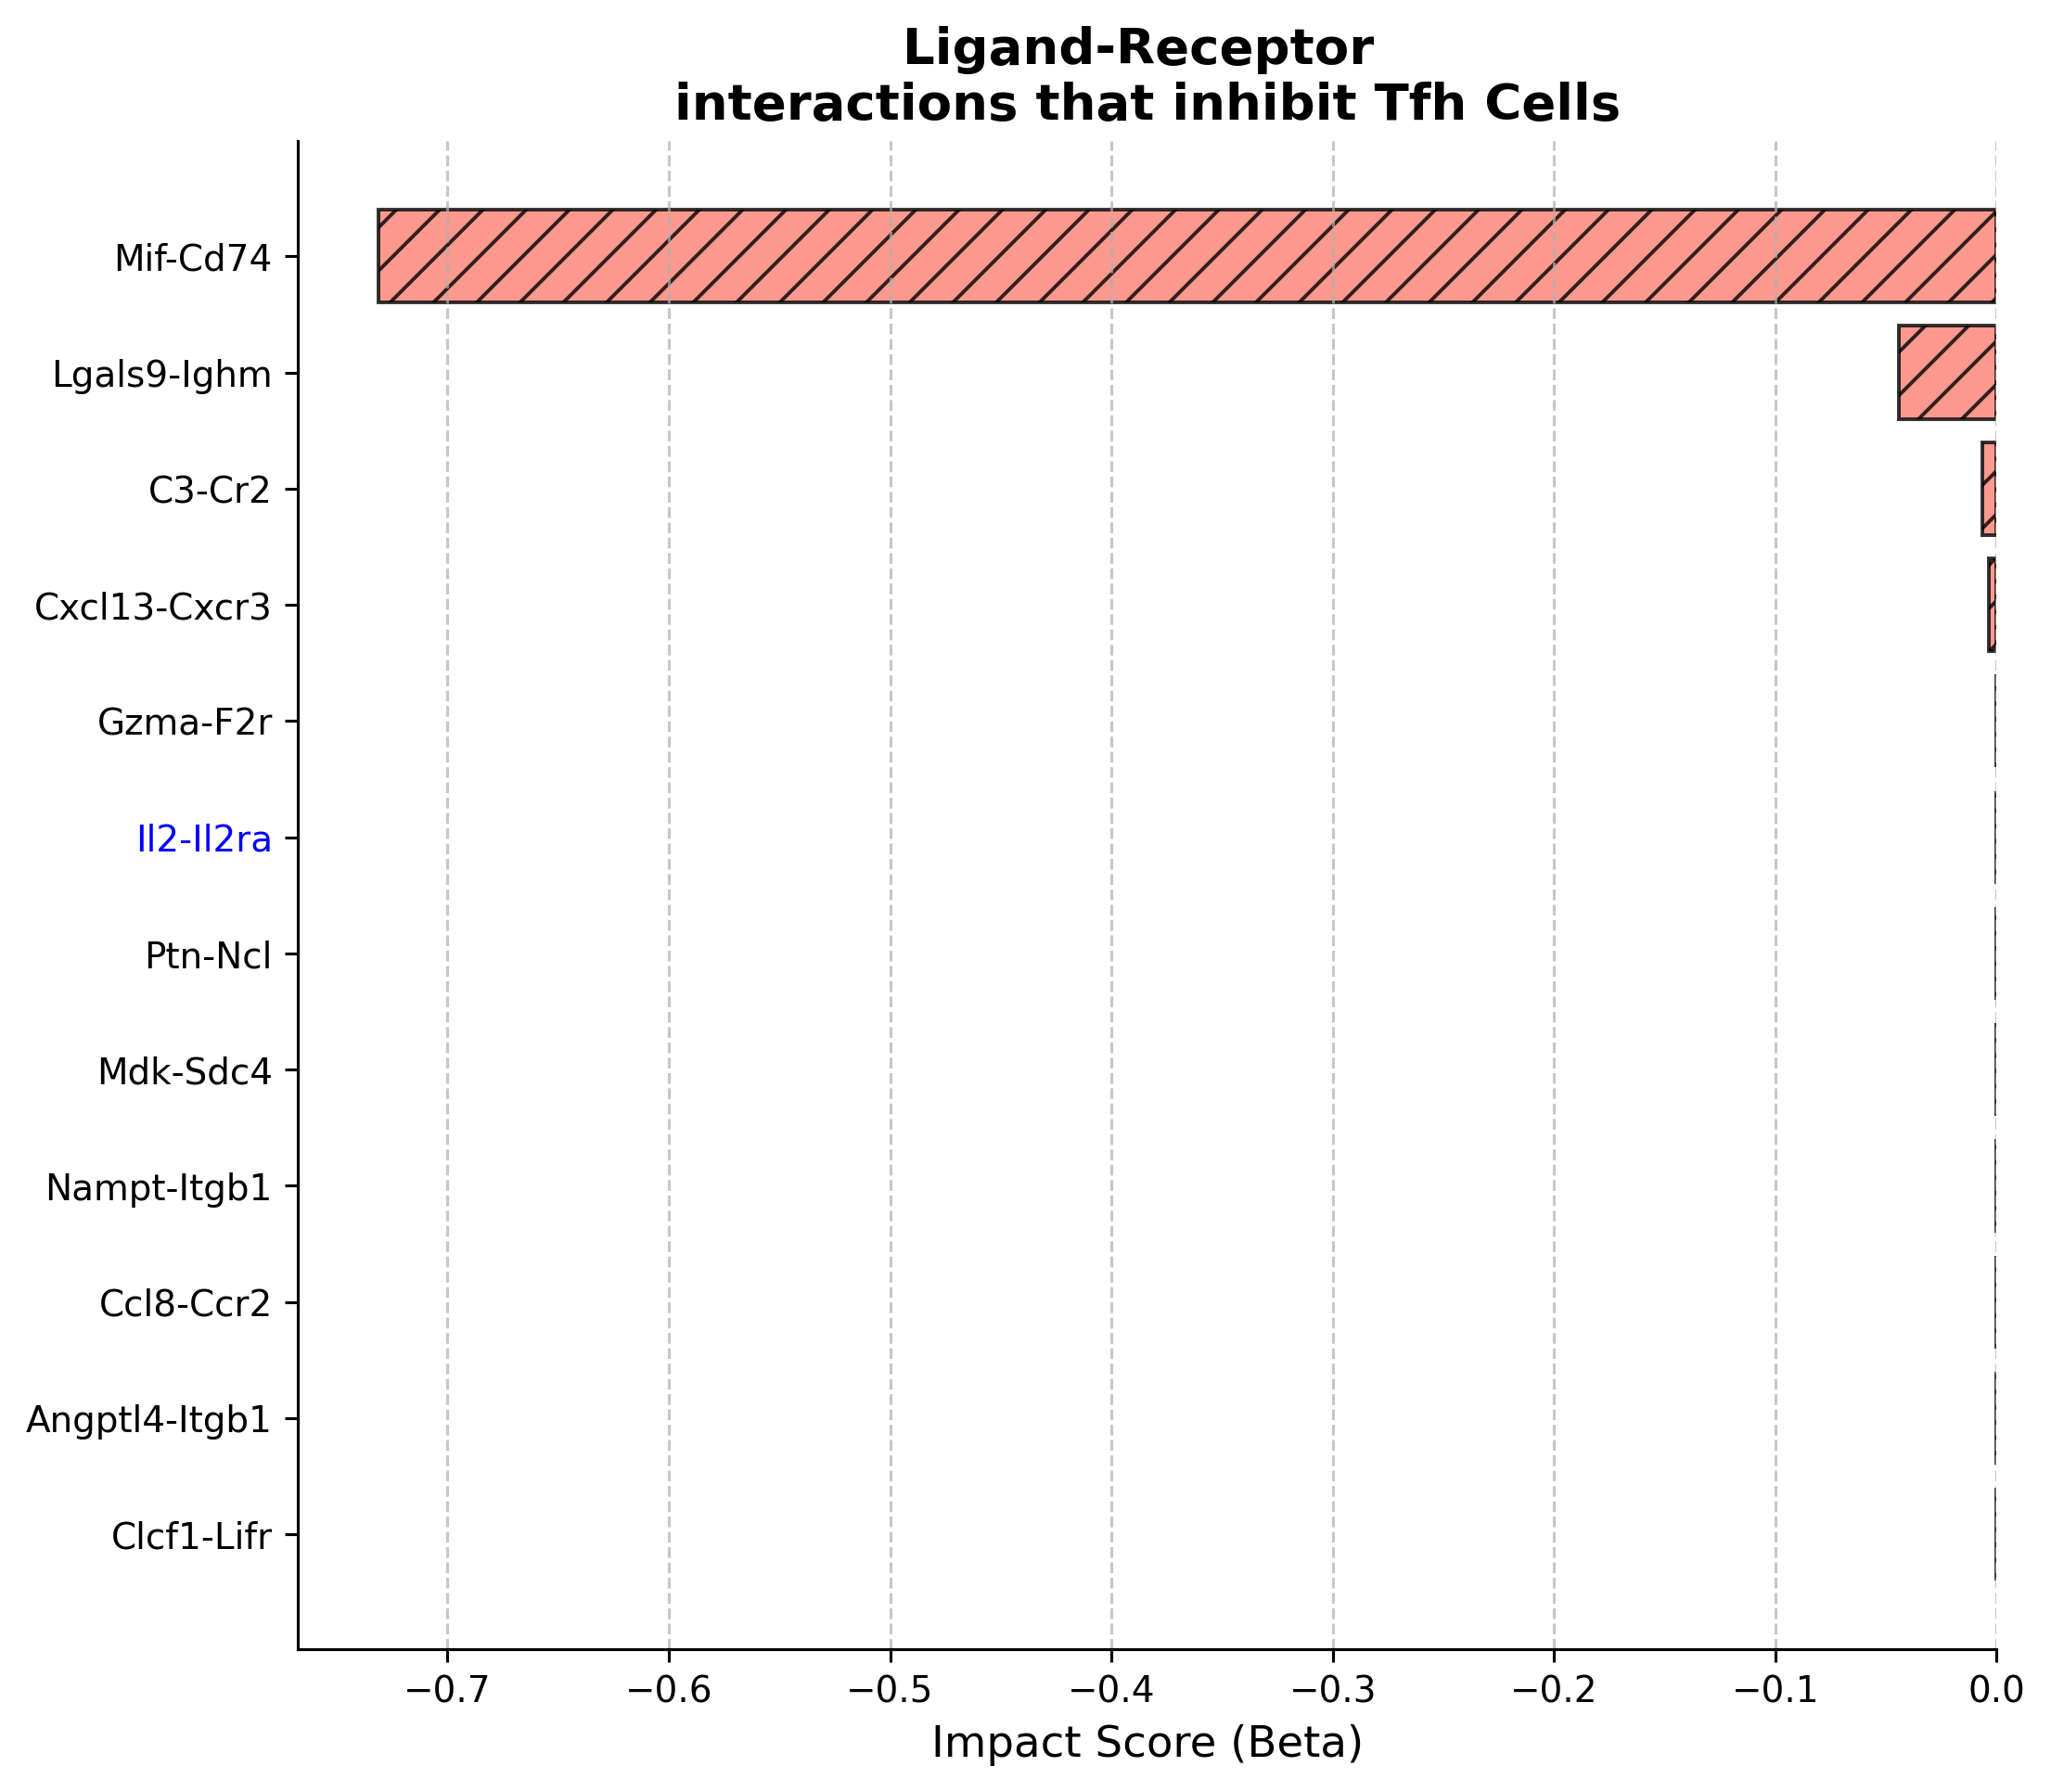

In [26]:
top_interactions = dfr[dfr['beta'] < 0].sort_values(
    by='beta', ascending=True).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that inhibit Tfh Cells', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Banksy

In [8]:
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [9]:
from spaceoracle.beta import Betabase

ct = 'Th2'
bdb = Betabase(
    gf.adata[gf.adata.obs.cell_type == ct], 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=gf.adata[gf.adata.obs.cell_type == ct].obs_names,
    auto_load=False
)

In [10]:
interactions = {}

for ct in [2, 7, 9]:
    interactions[ct] = bdb.collect_interactions(
        cell_type=ct, 
        annot='banksy_cluster')

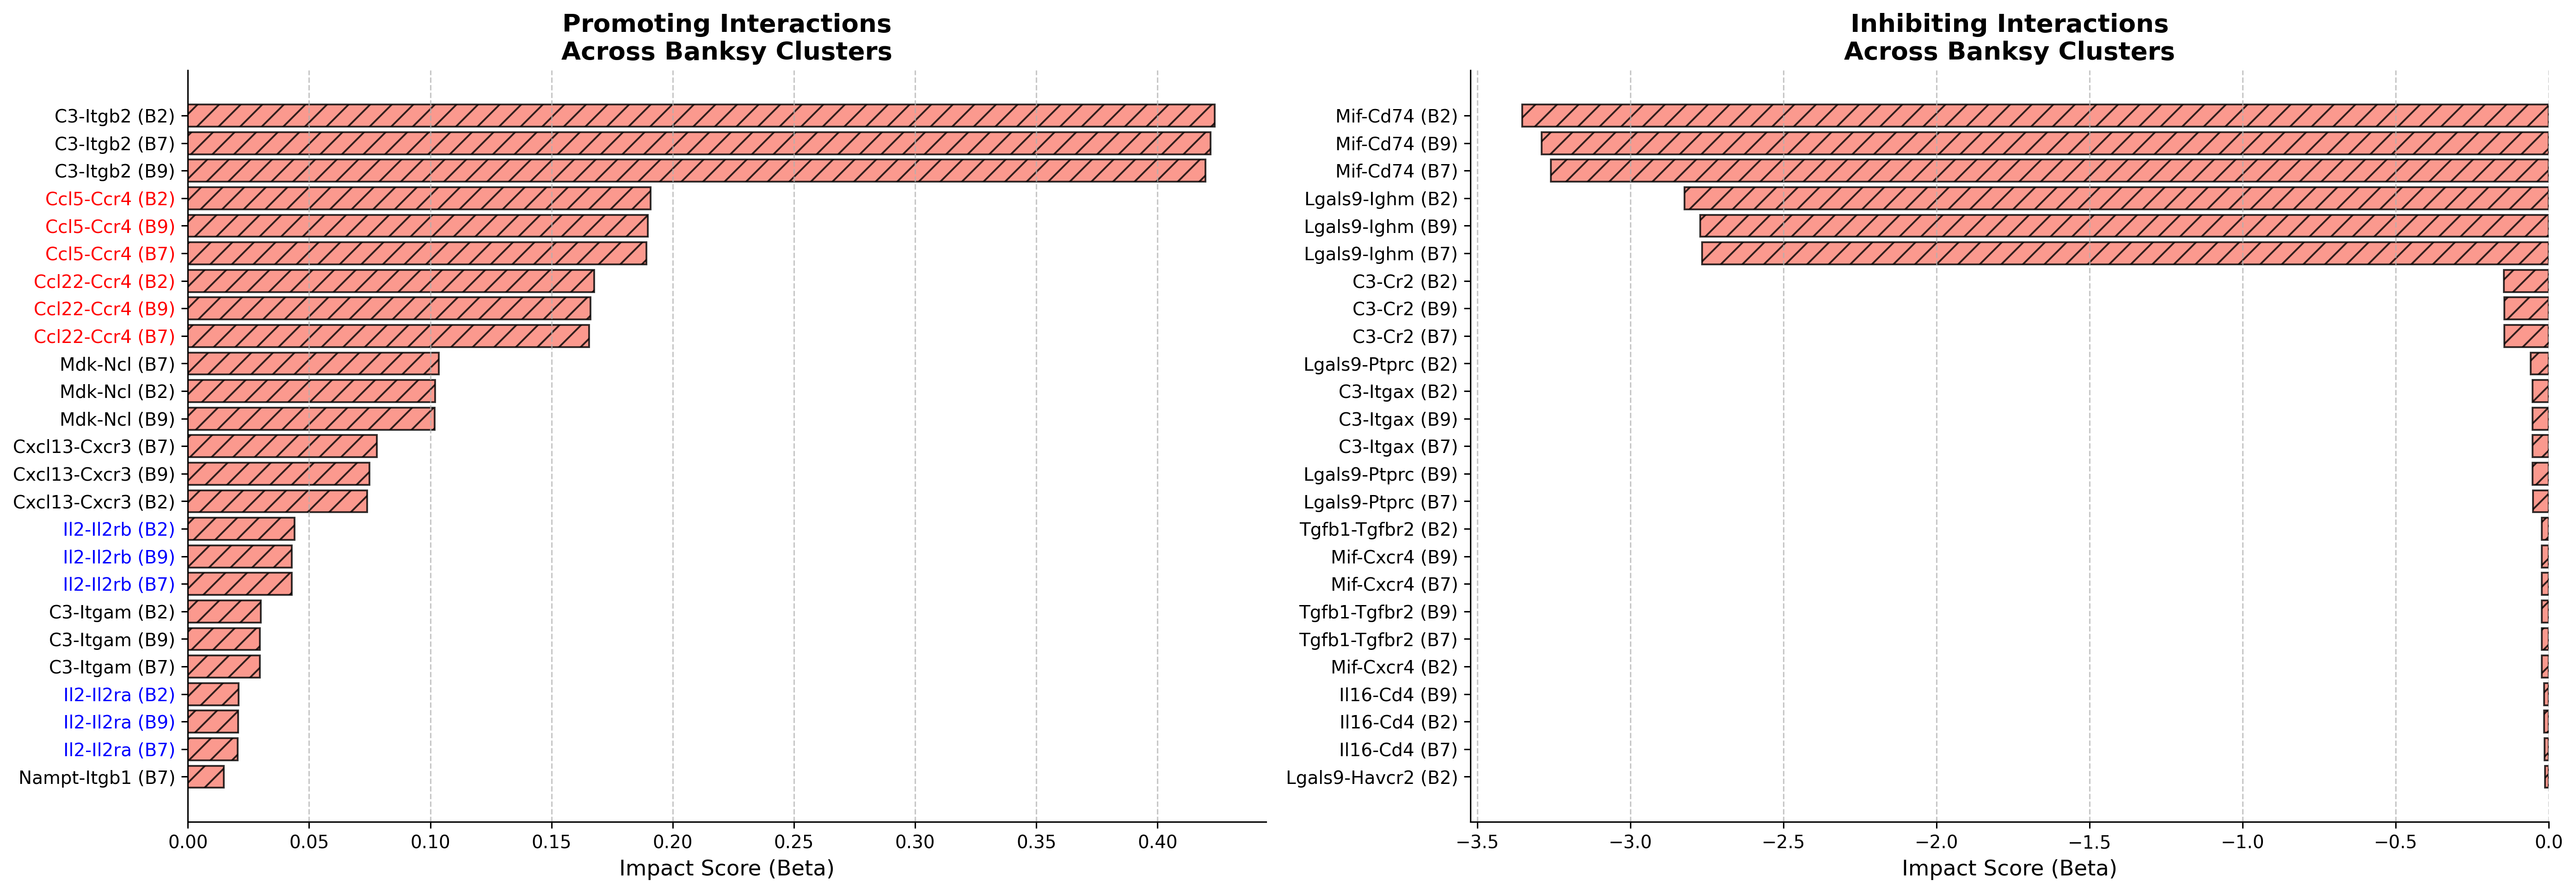

In [32]:
# 2, 7, 9
ct = 'Th2'

# Create two subplots - one for promoting and one for inhibiting interactions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), dpi=140)

# Process data for all banksy clusters
all_promoting = []
all_inhibiting = []

for bct in [2, 7, 9]:
    dfr = interactions[bct][interactions[bct]['gene'].isin(['Gata3', 'Il2ra', 'Il2rb', 'Il2rg'])].groupby(
        'interaction').sum().sort_values(by='beta', ascending=False)
    
    dfr['beta'] = dfr['beta'] * 100
    dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')
    
    # Add banksy cluster info to index
    dfr.index = [f"{idx} (B{bct})" for idx in dfr.index]
    
    # Split into promoting and inhibiting
    promoting = dfr[dfr['beta'] > 0].sort_values(by='beta', ascending=False).head(25)
    inhibiting = dfr[dfr['beta'] < 0].sort_values(by='beta', ascending=True).head(25)
    
    all_promoting.append(promoting)
    all_inhibiting.append(inhibiting)

# Combine all promoting and inhibiting interactions
combined_promoting = pd.concat(all_promoting).sort_values(by='beta', ascending=False).head(25)[::-1]
combined_inhibiting = pd.concat(all_inhibiting).sort_values(by='beta', ascending=True).head(25)[::-1]

# Plot promoting interactions
bars1 = ax1.barh(combined_promoting.index, combined_promoting['beta'],
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

# Plot inhibiting interactions
bars2 = ax2.barh(combined_inhibiting.index, combined_inhibiting['beta'],
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

# Color labels for both plots
for ax in [ax1, ax2]:
    ylabels = [label.get_text() for label in ax.get_yticklabels()]
    for label in ylabels:
        if 'Ccr4' in label:
            ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
            ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
    
    ax.set_xlabel('Impact Score (Beta)', fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax1.set_title('Promoting Interactions\nAcross Banksy Clusters', fontsize=14, fontweight='bold')
ax2.set_title('Inhibiting Interactions\nAcross Banksy Clusters', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()